<h1>KNN Exploration</h1>
This notebook will contain Erika's contribution to the assignment. To start with, Erika will look at using KNN on the Kickstarter data. If this proves uninteresting (and as time allows) Erika will also work on applying SVM to similar data.

In [62]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For KNN stuff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# For KNN scaling transformation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from copy import deepcopy

In [63]:
def load_preprocessed_data(name):
    # TODO: as additional preprocessing is completed, add options here.
    if name == 'basic_name':
        x_train = pd.read_csv("data/preprocess-{}-x-train-correct.csv".format(name), index_col=0)
        y_train = pd.read_csv("data/preprocess-{}-y-train-correct.csv".format(name), squeeze=True)
        x_valid = pd.read_csv("data/preprocess-{}-x-valid-correct.csv".format(name), index_col=0)
        y_valid = pd.read_csv("data/preprocess-{}-y-valid-correct.csv".format(name), squeeze=True)
    elif name == 'base' or name == 'doc2vec':
        x_train = pd.read_csv("data/preprocess-{}-x-train.csv".format(name), index_col=0)
        y_train = pd.read_csv("data/preprocess-{}-y-train.csv".format(name), squeeze=True)
        x_valid = pd.read_csv("data/preprocess-{}-x-valid.csv".format(name), index_col=0)
        y_valid = pd.read_csv("data/preprocess-{}-y-valid.csv".format(name), squeeze=True)
    else:
        raise Exception("No preprocessd data available for that name.")
    return x_train, y_train, x_valid, y_valid
        

We want to run all of our algorithms - including KNN, in this notebook - on several different versions of preprocessed data. Load them all here.

In [64]:
x_train_base, y_train_base, x_valid_base, y_valid_base = load_preprocessed_data('base')
x_train_d2v, y_train_d2v, x_valid_d2v, y_valid_d2v = load_preprocessed_data('doc2vec')
x_train_basic, y_train_basic, x_valid_basic, y_valid_basic = load_preprocessed_data('basic_name')
# TODO: load addtional preprocessed data

In [65]:
print(len(x_train_base))
print(len(y_train_base))
x_train_base.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month,deadline_month
0,12,19,-0.316333,-0.036515,4.0,5.0
2,8,136,2.025723,-0.031740,10.0,0.0
4,7,44,-0.272265,-0.032463,7.0,8.0
5,5,31,-0.400095,-0.034948,2.0,3.0
6,6,93,-0.326225,0.008140,0.0,2.0


In [66]:
print(len(x_train_d2v))
print(len(y_train_d2v))
x_train_d2v.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month,deadline_month,doc2vec_names_0,doc2vec_names_1,doc2vec_names_2,doc2vec_names_3,...,doc2vec_names_10,doc2vec_names_11,doc2vec_names_12,doc2vec_names_13,doc2vec_names_14,doc2vec_names_15,doc2vec_names_16,doc2vec_names_17,doc2vec_names_18,doc2vec_names_19
0,12,19,-0.316333,-0.036515,4.0,5.0,0.009077,-0.029281,-0.014818,-0.017581,...,0.013778,-0.047939,-0.063131,0.015074,-0.003315,-0.072243,0.029401,-0.058894,-0.008851,-0.004987
2,8,136,2.025723,-0.031740,10.0,0.0,-0.015903,0.037791,-0.035279,-0.029695,...,-0.055231,-0.034383,0.003102,0.029496,-0.097409,-0.059037,0.045664,-0.052574,0.034218,0.041212
4,7,44,-0.272265,-0.032463,7.0,8.0,0.018435,0.037622,0.031674,-0.049406,...,-0.048317,0.023729,-0.057103,0.023843,0.044732,-0.049317,-0.029703,-0.100054,0.014423,0.055918
5,5,31,-0.400095,-0.034948,2.0,3.0,0.020175,-0.015965,-0.012979,-0.058172,...,-0.008836,-0.055694,-0.005870,0.016705,-0.025267,0.002448,0.018852,-0.024194,0.007968,0.031140
6,6,93,-0.326225,0.008140,0.0,2.0,0.005605,0.003581,0.019905,-0.063847,...,-0.033168,-0.017154,-0.019477,0.027361,-0.083247,0.006590,-0.020938,-0.052568,-0.026672,0.040495


In [67]:
x_train_basic.head()

,Unnamed: 0.1,main_category,category,duration,usd_goal_real,launched_month_deadline_month_0,launched_month_deadline_month_1,num_chars,num_unusual_words,num_weird_chars
0,0,12,19,-0.316333,-0.036515,4.0,5.0,56,1,2
1,2,8,136,2.025723,-0.031740,10.0,0.0,30,2,0
2,4,7,44,-0.272265,-0.032463,7.0,8.0,60,4,0
3,5,5,31,-0.400095,-0.034948,2.0,3.0,34,3,1
4,6,6,93,-0.326225,0.008140,0.0,2.0,49,2,6


In [68]:
# Had to rename due to a change in preprocessing. The values are the same, just not the column names.x_train_basic.columns = ['index', 'main_category', 'category', 'duration', 'usd_goal_real', 'launched_month', 'deadline_month', 'num_chars', 'num_unusual_words', 'num_weird_chars']
x_train_basic.set_index('Unnamed: 0.1', drop=True, inplace=True)
x_valid_basic.set_index('Unnamed: 0.1', drop=True, inplace=True)

print(len(x_train_basic))
print(len(y_train_basic))
x_train_basic.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month_deadline_month_0,launched_month_deadline_month_1,num_chars,num_unusual_words,num_weird_chars
Unnamed: 0.1,,,,,,,,,
0,12,19,-0.316333,-0.036515,4.0,5.0,56,1,2
2,8,136,2.025723,-0.031740,10.0,0.0,30,2,0
4,7,44,-0.272265,-0.032463,7.0,8.0,60,4,0
5,5,31,-0.400095,-0.034948,2.0,3.0,34,3,1
6,6,93,-0.326225,0.008140,0.0,2.0,49,2,6


In [57]:
y_train_base.head()

0     True
1     True
2    False
3    False
4    False
Name: success, dtype: bool

In [58]:
y_train_d2v.head()

0     True
1     True
2    False
3    False
4    False
Name: success, dtype: bool

In [59]:
y_train_basic.head()

0     True
1     True
2    False
3    False
4    False
Name: 1, dtype: bool

In [30]:
def get_base_scaled_mapper():
    mapper = DataFrameMapper([
        (['usd_goal_real'], None),
        (['duration'], None),
        (['launched_month'], MinMaxScaler()),
        (['deadline_month'], MinMaxScaler()),
        (['category'], MinMaxScaler()),
        (['main_category'], MinMaxScaler()),
    ], df_out=True)
    return mapper

def get_base_ohe_mapper():
    mapper = DataFrameMapper([
        (['usd_goal_real'], None),
        (['duration'], None),
        (['main_category'], OneHotEncoder()),
        (['launched_month'], OneHotEncoder()),
        (['deadline_month'], OneHotEncoder()),
        (['category'], None),
    ], df_out=True)
    return mapper

def get_knn_basic_mapper():
    mapper = DataFrameMapper([
        (['usd_goal_real'], None),
        (['duration'], None),
        (['main_category'], None),
        (['launched_month_deadline_month_0'], None),
        (['launched_month_deadline_month_1'], None),
        (['category'], None),
        (['num_chars'], MinMaxScaler()),
        (['num_unusual_words'], MinMaxScaler()),
        (['num_weird_chars'], MinMaxScaler())
    ], df_out=True)
    return mapper

In [31]:
%%time
scaled_mapper = get_base_scaled_mapper()
x_train_base_scaled = scaled_mapper.fit_transform(x_train_base)
x_valid_base_scaled = scaled_mapper.transform(x_valid_base)

ohe_mapper = get_base_ohe_mapper()
x_train_base_ohe = ohe_mapper.fit_transform(x_train_base)
x_valid_base_ohe = ohe_mapper.transform(x_valid_base)

basic_mapper = get_knn_basic_mapper()
x_train_basic_scaled = basic_mapper.fit_transform(x_train_basic)
x_valid_basic_scaled = basic_mapper.transform(x_valid_basic)

/users/hunhoffe/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/users/hunhoffe/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='

CPU times: user 14.4 s, sys: 300 ms, total: 14.7 s
Wall time: 1.07 s


In [19]:
x_train_basic_scaled.head()

,usd_goal_real,duration,main_category,launched_month_deadline_month_0,launched_month_deadline_month_1,category,num_chars,num_unusual_words,num_weird_chars
Unnamed: 0.1,,,,,,,,,
0,-0.036515,-0.316333,12,4.0,5.0,19,0.597826,0.111111,0.037037
2,-0.031740,2.025723,8,10.0,0.0,136,0.315217,0.222222,0.000000
4,-0.032463,-0.272265,7,7.0,8.0,44,0.641304,0.444444,0.000000
5,-0.034948,-0.400095,5,2.0,3.0,31,0.358696,0.333333,0.018519
6,0.008140,-0.326225,6,0.0,2.0,93,0.521739,0.222222,0.111111


In [20]:
x_train_base_scaled.head()

,usd_goal_real,duration,launched_month,deadline_month,category,main_category
0,-0.036515,-0.316333,0.363636,0.454545,0.120253,0.857143
2,-0.031740,2.025723,0.909091,0.000000,0.860759,0.571429
4,-0.032463,-0.272265,0.636364,0.727273,0.278481,0.500000
5,-0.034948,-0.400095,0.181818,0.272727,0.196203,0.357143
6,0.008140,-0.326225,0.000000,0.181818,0.588608,0.428571


In [21]:
x_train_base_ohe.head()

,usd_goal_real,duration,main_category_x0_0.0,main_category_x0_1.0,main_category_x0_2.0,main_category_x0_3.0,main_category_x0_4.0,main_category_x0_5.0,main_category_x0_6.0,main_category_x0_7.0,...,category_x0_149.0,category_x0_150.0,category_x0_151.0,category_x0_152.0,category_x0_153.0,category_x0_154.0,category_x0_155.0,category_x0_156.0,category_x0_157.0,category_x0_158.0
0,-0.036515,-0.316333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.031740,2.025723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.032463,-0.272265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.034948,-0.400095,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.008140,-0.326225,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Start by looking at scikit learn nearest neightbors
def try_knn(x_train, y_train, x_valid, y_valid, neighbors, weights, algorithm='auto'):
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm, n_jobs=8)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_valid)
    return knn, metrics.accuracy_score(y_valid, y_pred)

In [23]:
def get_scores(n_low, n_high, n_step, x_train, y_train, x_valid, y_valid, weights=['uniform', 'distance']):
    print("Calling 'get_scores'")
    max_score = (0, None, None, None)
    scores = {}
    for w in weights:
        print("Looking at weight measurement: {}".format(w))
        scores["{}".format(w)] = []
        for n in range(n_low, n_high + 1, n_step):
            knn, score = try_knn(x_train, y_train, x_valid, y_valid, neighbors=n, weights=w)
            if (n % 5 == 0):
                print("\tFor {: 3} neighbors, score: {}".format(n, score))
            scores["{}".format(w)].append((n, score))
            if max_score[0] < score:
                max_score = (score, w, n, knn)
    return max_score, scores

In [ ]:
def plot_scores(scores, title='A graph plotting number of neighbors and scores'):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']

    for i, (key, score_array) in enumerate(scores.items()):
        ns = [n for (n, _) in score_array]
        ss = [s for (_, s) in score_array]
        line, = ax.plot(ns, ss, color=colors[i])
        line.set_label(key)
    
    # Label axes
    ax.set(xlabel='K (Number of Neighbors)', ylabel='Accuracy on Validation Data', title=title)

    ax.legend()
    return plt

<h3>Parameter Tuning and Scaling Checks</h3>
The below runs are to start tuning the numbers of neighbors, and also check to see if the MinMaxScaling was effective at all in increasing accuracy.

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6494631417486241
	For  50 neighbors, score: 0.6518090769647208
	For  75 neighbors, score: 0.6534632620529941
	For  100 neighbors, score: 0.6536136425155644
	For  125 neighbors, score: 0.653914403440705
	For  150 neighbors, score: 0.6534031098679659
	For  175 neighbors, score: 0.6512075551144395
	For  200 neighbors, score: 0.6511474029294114
	For  225 neighbors, score: 0.6509970224668411
	For  250 neighbors, score: 0.6492826851935397
	For  275 neighbors, score: 0.6485007067881741
	For  300 neighbors, score: 0.6476585761977803
	For  325 neighbors, score: 0.6466359890523024
	For  350 neighbors, score: 0.6463953803121898
	For  375 neighbors, score: 0.6455532497217962
	For  400 neighbors, score: 0.646485608589732
	For  425 neighbors, score: 0.645493097536768
	For  450 neighbors, score: 0.6441095972811213
	For  475 neighbors, score: 0.6428464013955307
	For  500 neighbors, score: 0.6421546512677073
Lookin

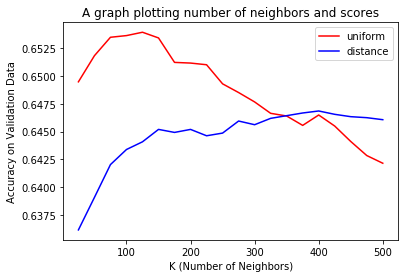

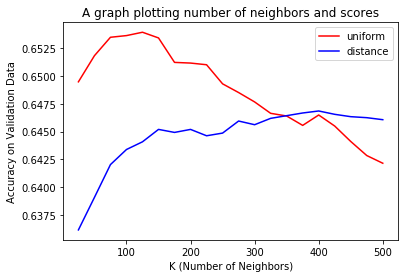

In [25]:
%%time
max_score_base, scores_base = get_scores(25, 501, 25, 
                                         x_train_base, 
                                         y_train_base, 
                                         x_valid_base, 
                                         y_valid_base)
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6394778790339559
	For  50 neighbors, score: 0.6425456404703901
	For  75 neighbors, score: 0.6418238142500526
	For  100 neighbors, score: 0.6417636620650246
	For  125 neighbors, score: 0.6381846070558513
	For  150 neighbors, score: 0.6371018677253452
	For  175 neighbors, score: 0.6349664651568468
	For  200 neighbors, score: 0.6346356281391922
	For  225 neighbors, score: 0.6338837258263407
	For  250 neighbors, score: 0.6324701494781798
	For  275 neighbors, score: 0.6308159643899065
	For  300 neighbors, score: 0.6297933772444284
	For  325 neighbors, score: 0.6286805618214082
	For  350 neighbors, score: 0.6261842461427412
	For  375 neighbors, score: 0.6259436374026287
	For  400 neighbors, score: 0.6239285392041866
	For  425 neighbors, score: 0.6239886913892148
	For  450 neighbors, score: 0.6244699088694396
	For  475 neighbors, score: 0.6242293001293272
	For  500 neighbors, score: 0.6239586152967006
Loo

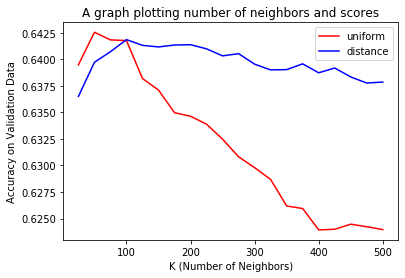

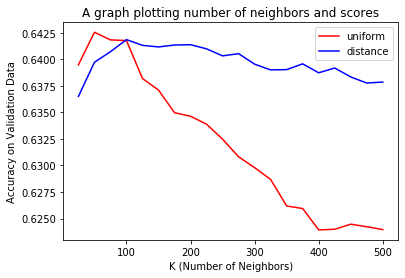

In [26]:
%%time
max_score_base_scaled, scores_base_scaled = get_scores(25, 501, 25, 
                                         x_train_base_scaled, 
                                         y_train_base, 
                                         x_valid_base_scaled, 
                                         y_valid_base)
print("The max score is: {} (w={}, n={})".format(max_score_base_scaled[0], max_score_base_scaled[1], max_score_base_scaled[2]))
plot_scores(scores_base_scaled)

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6492826851935397
	For  50 neighbors, score: 0.6502751962465037
	For  75 neighbors, score: 0.6503955006165599
	For  100 neighbors, score: 0.6521098378898613
	For  125 neighbors, score: 0.6515083160395801
	For  150 neighbors, score: 0.6505458810791303
	For  175 neighbors, score: 0.648951848175885
	For  200 neighbors, score: 0.6502451201539896
	For  225 neighbors, score: 0.6501548918764474
	For  250 neighbors, score: 0.6501548918764474
	For  275 neighbors, score: 0.6502751962465037
	For  300 neighbors, score: 0.6500947396914193
	For  325 neighbors, score: 0.6515383921320942
	For  350 neighbors, score: 0.6523805227224879
	For  375 neighbors, score: 0.6509669463743271
	For  400 neighbors, score: 0.6513579355770098
	For  425 neighbors, score: 0.650936870281813
	For  450 neighbors, score: 0.6514481638545521
	For  475 neighbors, score: 0.6508165659117567
	For  500 neighbors, score: 0.6497037504887365
Looki

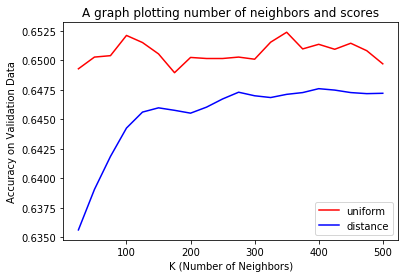

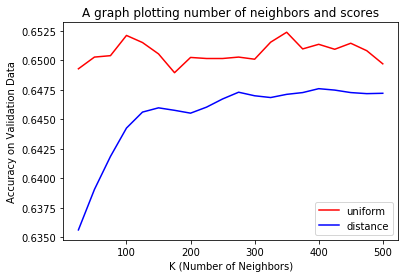

In [32]:
%%time
max_score_base_ohe, scores_base_ohe = get_scores(25, 501, 25, 
                                         x_train_base_ohe, 
                                         y_train_base, 
                                         x_valid_base_ohe, 
                                         y_valid_base)
print("The max score is: {} (w={}, n={})".format(max_score_base_ohe[0], max_score_base_ohe[1], max_score_base_ohe[2]))
plot_scores(scores_base_ohe)

We want to create a combined graph of the past two results, to help determine is the additional normalization does anything.

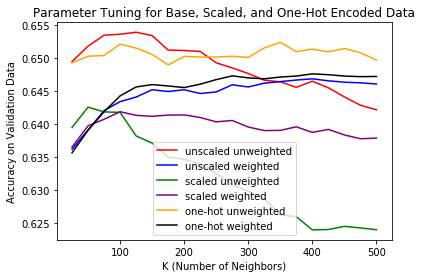

In [34]:
combined_scores_initial = {}
combined_scores_initial['unscaled unweighted'] = scores_base['uniform']
combined_scores_initial['unscaled weighted'] = scores_base['distance']
combined_scores_initial['scaled unweighted'] = scores_base_scaled['uniform']
combined_scores_initial['scaled weighted'] = scores_base_scaled['distance']
combined_scores_initial['one-hot unweighted'] = scores_base_ohe['uniform']
combined_scores_initial['one-hot weighted'] = scores_base_ohe['distance']
fig = plot_scores(combined_scores_initial, title='Parameter Tuning for Base, Scaled, and One-Hot Encoded Data')
fig.savefig('knn_params.png', dpi=300)
plt.show()

<h3> Initial Results </h3>
MinMaxScaling appears to boost accuracy just a bit. Now that I've narrowed down a likely range for good values for neighbors, I'll do a more fine-grained search with all of the data. I've also seen that distance seems to work best, so I'll start only considering distance weights.

Calling 'get_scores'
Looking at weight measurement: uniform
	For  75 neighbors, score: 0.6534632620529941
	For  90 neighbors, score: 0.6533730337754519
	For  105 neighbors, score: 0.6533429576829378
	For  120 neighbors, score: 0.6545460013835003
	For  135 neighbors, score: 0.6531625011278535
	For  150 neighbors, score: 0.6534031098679659
	For  165 neighbors, score: 0.6515383921320942
	For  180 neighbors, score: 0.6509970224668411
	For  195 neighbors, score: 0.6506060332641583
Looking at weight measurement: distance
	For  75 neighbors, score: 0.642034346897651
	For  90 neighbors, score: 0.6434178471532979
	For  105 neighbors, score: 0.6432975427832416
	For  120 neighbors, score: 0.6437486841709525
	For  135 neighbors, score: 0.6445306625763181
	For  150 neighbors, score: 0.6451923366116274
	For  165 neighbors, score: 0.6446509669463744
	For  180 neighbors, score: 0.6451321844265993
	For  195 neighbors, score: 0.6450720322415712
The max score is: 0.6451923366116274 (w=distance, n=150)
CP

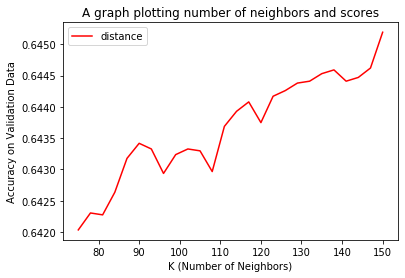

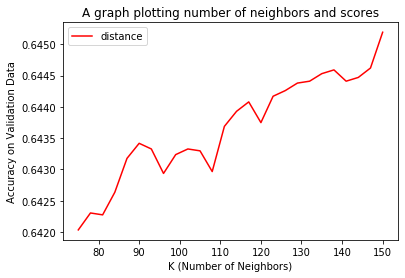

In [45]:
%%time
max_score_base_uniform, scores_base_uniform = get_scores(75, 200, 3, 
                                         x_train_base, 
                                         y_train_base, 
                                         x_valid_base, 
                                         y_valid_base,
                                        weights=['uniform', 'distance'])
print("The max score is: {} (w={}, n={})".format(max_score_base_distance[0], max_score_base_distance[1], max_score_base_distance[2]))
plot_scores(scores_base_uniform)

K=117, score=0.6549971427712111


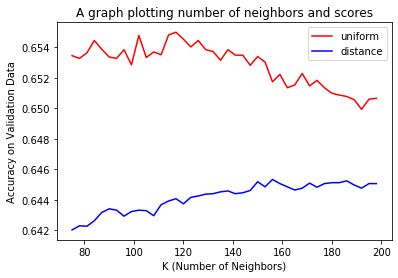

In [74]:
plot_scores(scores_base_uniform)
max_score = 0
max_k = 0
for (k, score) in scores_base_uniform['uniform']:
    if score > max_score:
        max_score = score
        max_k = k
print("K={}, score={}".format(max_k, max_score))

Calling 'get_scores'
Looking at weight measurement: uniform
	For  75 neighbors, score: 0.6531324250353394
	For  90 neighbors, score: 0.6537640229781346
	For  105 neighbors, score: 0.6529820445727691
	For  120 neighbors, score: 0.6535234142380222
	For  135 neighbors, score: 0.6527715119251707
	For  150 neighbors, score: 0.6525609792775723
	For  165 neighbors, score: 0.6522000661674036
	For  180 neighbors, score: 0.6517489247796926
	For  195 neighbors, score: 0.6507864898192427
Looking at weight measurement: distance
	For  75 neighbors, score: 0.6537038707931065
	For  90 neighbors, score: 0.6535234142380222
	For  105 neighbors, score: 0.6534632620529941
	For  120 neighbors, score: 0.6541249360883034
	For  135 neighbors, score: 0.653944479533219
	For  150 neighbors, score: 0.6540948599957893
	For  165 neighbors, score: 0.6538542512556769
	For  180 neighbors, score: 0.6535534903305362
	For  195 neighbors, score: 0.6530121206652831
The max score is: 0.654455773105958 (w=distance, n=111)
CPU

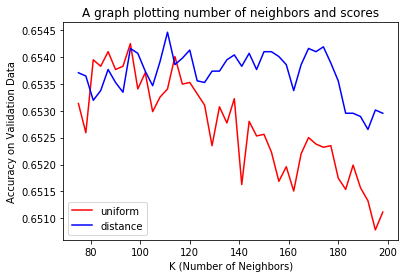

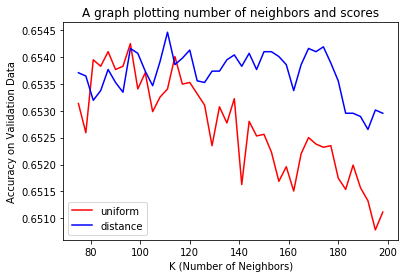

In [47]:
%%time
max_score_d2v, scores_d2v = get_scores(75, 200, 3, 
                                         x_train_d2v, 
                                         y_train_d2v, 
                                         x_valid_d2v, 
                                         y_valid_d2v,
                                        weights=['uniform', 'distance'])
print("The max score is: {} (w={}, n={})".format(max_score_d2v[0], max_score_d2v[1], max_score_d2v[2]))
plot_scores(scores_d2v)

Calling 'get_scores'
Looking at weight measurement: uniform
	For  75 neighbors, score: 0.6421546512677073
	For  90 neighbors, score: 0.6417335859725104
	For  105 neighbors, score: 0.6403801618093777
	For  120 neighbors, score: 0.6407109988270324
	For  135 neighbors, score: 0.6397786399590966
	For  150 neighbors, score: 0.63950795512647
	For  165 neighbors, score: 0.6394478029414419
	For  180 neighbors, score: 0.6392071942013293
	For  195 neighbors, score: 0.6386357484435622
Looking at weight measurement: distance
	For  75 neighbors, score: 0.6337934975487984
	For  90 neighbors, score: 0.6339438780113688
	For  105 neighbors, score: 0.6345153237691359
	For  120 neighbors, score: 0.6330415952359469
	For  135 neighbors, score: 0.6348762368793046
	For  150 neighbors, score: 0.6343047911215375
	For  165 neighbors, score: 0.6348762368793046
	For  180 neighbors, score: 0.6347258564167343
	For  195 neighbors, score: 0.6349664651568468
The max score is: 0.6431471623206713 (w=uniform, n=81)
CPU t

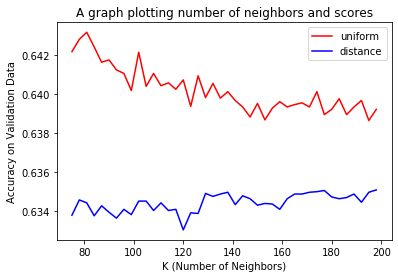

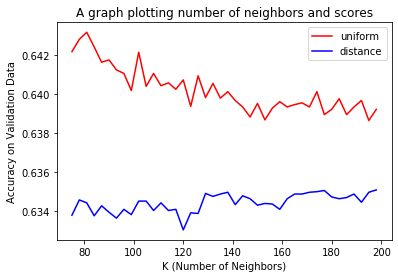

In [69]:
%%time
max_score_basic, scores_basic = get_scores(75, 200, 3, 
                                         x_train_basic, 
                                         y_train_basic, 
                                         x_valid_basic, 
                                         y_valid_basic,
                                        weights=['uniform', 'distance'])
print("The max score is: {} (w={}, n={})".format(max_score_basic[0], max_score_basic[1], max_score_basic[2]))
plot_scores(scores_basic)

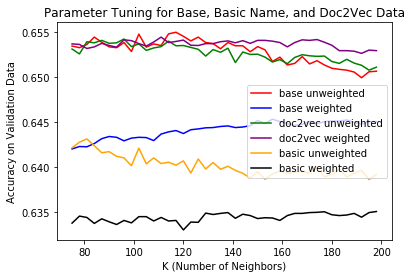

In [72]:
combined_scores_prep = {}
combined_scores_prep['base unweighted'] = scores_base_uniform['uniform']
combined_scores_prep['base weighted'] = scores_base_uniform['distance']
combined_scores_prep['doc2vec unweighted'] = scores_d2v['uniform']
combined_scores_prep['doc2vec weighted'] = scores_d2v['distance']
combined_scores_prep['basic unweighted'] = scores_basic['uniform']
combined_scores_prep['basic weighted'] = scores_basic['distance']
fig = plot_scores(combined_scores_prep, title='Parameter Tuning for Base, Basic Name, and Doc2Vec Data')
fig.savefig('knn_datasets.png', dpi=300)
plt.show()

The maximum is on the base dataset, K=117, uniform (unweighted) distance metric, with a score of 0.6549971427712111 on validation data.


Max score for d2v on validation: The max score is: 0.654455773105958 (w=distance, n=111)s


In [77]:
x_test_base = pd.read_csv("data/preprocess-base-x-test.csv", index_col=0)
y_test_base = pd.read_csv("data/preprocess-base-y-test.csv", squeeze=True)

x_test_d2v = pd.read_csv("data/preprocess-doc2vec-x-test.csv", index_col=0)
y_test_d2v = pd.read_csv("data/preprocess-doc2vec-y-test.csv", squeeze=True)

In [78]:
test_score_base = try_knn(x_train_base, y_train_base, x_test_base, y_test_base, 117, 'distance')
print(test_score_base)

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=117, p=2,
                     weights='distance'), 0.6499690043393925)


In [79]:
test_score_d2v = try_knn(x_train_d2v, y_train_d2v, x_test_d2v, y_test_d2v, 111, 'distance')
print(test_score_d2v)

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=111, p=2,
                     weights='distance'), 0.6568280440738297)
